<a href="https://colab.research.google.com/github/SimBoex/GenerateSpokenDigits_vae/blob/main/notebook_2_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
Remember to use only tensorflow (otherwise problems with keras)
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import librosa
import tensorflow.keras.backend as K
import IPython.display as ipd
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!mkdir -p ~/ .kaggle


In [4]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/


In [5]:
!chmod 600 ~/ .kaggle/kaggle.json


In [6]:
!kaggle datasets download -d joserzapata/free-spoken-digit-dataset-fsdd

Dataset URL: https://www.kaggle.com/datasets/joserzapata/free-spoken-digit-dataset-fsdd
License(s): CC-BY-SA-4.0
 58% 9.00M/15.5M [00:00<00:00, 19.1MB/s]
100% 15.5M/15.5M [00:00<00:00, 32.1MB/s]


In [7]:
!unzip free-spoken-digit-dataset-fsdd.zip

Archive:  free-spoken-digit-dataset-fsdd.zip
  inflating: .gitignore              
  inflating: README.md               
  inflating: __init__.py             
  inflating: acquire_data/say_numbers_prompt.py  
  inflating: acquire_data/split_and_label_numbers.py  
  inflating: metadata.py             
  inflating: pip_requirements.txt    
  inflating: recordings/0_george_0.wav  
  inflating: recordings/0_george_1.wav  
  inflating: recordings/0_george_10.wav  
  inflating: recordings/0_george_11.wav  
  inflating: recordings/0_george_12.wav  
  inflating: recordings/0_george_13.wav  
  inflating: recordings/0_george_14.wav  
  inflating: recordings/0_george_15.wav  
  inflating: recordings/0_george_16.wav  
  inflating: recordings/0_george_17.wav  
  inflating: recordings/0_george_18.wav  
  inflating: recordings/0_george_19.wav  
  inflating: recordings/0_george_2.wav  
  inflating: recordings/0_george_20.wav  
  inflating: recordings/0_george_21.wav  
  inflating: recordings/0_george_

In [8]:
seed = 42
import tensorflow as tf
tf.compat.v1.set_random_seed(seed)

In [9]:
PATH = "/content/recordings/"
LATENT_DIM = 2

In [24]:
'''
Classes for preprocessing:

'''

class Loader:
    def __init__(self,sample_rate, duration, mono) -> None:
        self.sample_rate = sample_rate
        self.duration = duration # only load up to this much audio (in seconds)
        self.mono = mono
        self._num_expected_samples = int(sample_rate * duration)

    def __init__(self) -> None:
        self.sample_rate = 22050
        self.duration=10
        self.mono = True
        self._num_expected_samples = int(self.sample_rate * self.duration)



    def load(self, file_path):
        # Load an audio file as a floating point time series.
        signal , sampling_rate = librosa.load(file_path,sr=self.sample_rate, duration=self.duration, mono = self.mono)
        return signal




In [11]:
class LogSpectrogramExtractor:
    """LogSpectrogramExtractor extracts log spectrograms (in dB) from a
    time-series signal.
    """
    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(signal,
                            n_fft=self.frame_size,
                            hop_length=self.hop_length)[:-1]

        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram



In [26]:
class Audio_utils:
    def __init__(self) -> None:
        self.min = 0
        self.max = 1
        self.min_max_values = {}
        self._num_expected_samples = None

    def setEXP_SAMPLES(self, value):
        self.EXP_SAMPLES=value

    def _is_padding_necessary(self, signal):
        if len(signal) < self.EXP_SAMPLES:
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self.EXP_SAMPLES - len(signal)
        padded_signal = self.right_pad(signal, num_missing_samples)
        return padded_signal

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items))
        return padded_array

    ##############################################################

    def normalise(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        return norm_array

    ##############################################################


    def generate_save_path(self, file_name):
        feature_save_dir = "./Spectrograms/"
        save_path = os.path.join(feature_save_dir, file_name + ".npy")
        return save_path

    def save_feature(self, feature, file_name):
        save_path = self.generate_save_path(file_name)
        np.save(save_path, feature)

    def save_min_max_values(self):
        save_path = os.path.join("min_max",
                                 "min_max_values.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(self.min_max_values, f)

    def store_min_max_value(self, save_path, min_val, max_val):

        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }


Let's start with testing some important methods:

In [14]:
l = Loader()
sample = l.load(file_path="/content/recordings/0_george_0.wav")

In [15]:
ipd.Audio(sample,rate=l.sample_rate)

In [16]:
# Define frame size and hop length
frame_size = 1024  # Number of samples per frame
hop_length = 256   # Number of samples between frames
sp = LogSpectrogramExtractor(frame_size=frame_size,hop_length=hop_length)
s = sp.extract(sample)

In [17]:
from IPython.display import Audio
# log spectrogram -> spectrogram
spec = librosa.db_to_amplitude(s)
# apply Griffin-Lim
signal = librosa.istft(spec, hop_length=hop_length)
Audio(signal,rate=l.sample_rate)

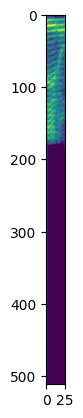

In [20]:
u = Audio_utils()
s1 = u.normalise(s)
plt.imshow(s1)
plt.show()

Some notes about Spectograms:
- They are generated using the Fourier Transform;
- Moreover using the Short-Fourier Transform since we define a frame(window) and compute the fourier transform on each segment;
- In this way, the Spectogram encoded also the information about how the frequency components change over time

Which are the output of the Fourier transform?
- a magnitude (expressing the similarity between the signal/segment and a sinuosoid with a given frequency)
- basically the obtained magnitudes for each frame are grouped and they generated a frequency vector

# Let's process the data

In [27]:
import os

audio_loader = Loader()
EXP_SAMPLES = audio_loader._num_expected_samples
######################################################################

# Define frame size and hop length
frame_size = 1024 # Number of samples per frame
hop_length = 256   # Number of samples between frames
audio_spectr = LogSpectrogramExtractor(frame_size=frame_size,hop_length=hop_length)
######################################################################

audio_utils = Audio_utils()
audio_utils.setEXP_SAMPLES(EXP_SAMPLES)
######################################################################


# Saving the features
for root, _, files in os.walk(PATH):
    for file in files:
        file_path = os.path.join(root, file)
        signal = audio_loader.load(file_path=file_path)
        # We need to perform padding on the signal!
        ##############################################
        if audio_utils._is_padding_necessary(signal):
            signal = audio_utils._apply_padding(signal)
        ##############################################
        spect = audio_spectr.extract(signal)
        norm_spect = audio_utils.normalise(spect)
        audio_utils.save_feature(norm_spect,file_name=file)
        ##############################################

        audio_utils.store_min_max_value(file,  spect.min(),  spect.max()) # for each spectrogram i save the min and the max
        audio_utils.save_min_max_values()


Since i want to generate new music i need a denormalization process. Therefore, I need to take the mean of the min and max values

In [29]:
data = audio_utils.min_max_values
min_values = [inner_dict['min'] for inner_dict in data.values()]
max_values = [inner_dict['max'] for inner_dict in data.values()]

min_values_np = np.array(min_values)
max_values_np = np.array(max_values)

# Calculate the mean using NumPy
mean_min = np.mean(min_values_np)
mean_max = np.mean(max_values_np)


Here, I need to split in train and val in order to test how good the chosen hyperparameters are

In [30]:
spect_names = list(os.listdir("/content/Spectrograms"))

In [31]:
from sklearn.model_selection import train_test_split

X_train_path, X_test_path = train_test_split(spect_names, test_size=0.2, random_state=42)

Let's train the model

In [32]:
spectrograms_path = "/content/Spectrograms"
x_train = []
for root, _, file_names in os.walk(spectrograms_path):
    for file_name in X_train_path:
        file_path = os.path.join(root, file_name)
        spectrogram = np.load(file_path) # (512, 862), a simple matrix
        x_train.append(spectrogram) # (2400, 512, 862)

x_test = []
for root, _, file_names in os.walk(spectrograms_path):
    for file_name in X_test_path:
        file_path = os.path.join(root, file_name)
        spectrogram = np.load(file_path) # (512, 862), a simple matrix
        x_test.append(spectrogram) # (600, 512, 862)

print(x_train[0].shape)
print(x_test[0].shape)


(512, 862)
(512, 862)


In [33]:
x_train = np.array(x_train)
x_train = x_train[..., np.newaxis] # -> (100, 512, 862, 1)

x_test = np.array(x_test)
x_test = x_test[..., np.newaxis] # -> (100, 512, 862, 1)

In [35]:
# Verify the shape and type of x_train
print(type(x_train))  # Should print <class 'numpy.ndarray'>
print(x_train.shape)  # Should print (2400, 512, 862, 1)

# Verify the shape and type of x_train
print(type(x_test))  # Should print <class 'numpy.ndarray'>
print(x_test.shape)  # Should print (600, 512, 862, 1)

<class 'numpy.ndarray'>
(2400, 512, 862, 1)
<class 'numpy.ndarray'>
(600, 512, 862, 1)


now we are ready to train a model, since we have a numpy array with each element a matrix of 1 dimension

# Model

we use a VAE model.

- Features:
    - Encoder
        - Given an input, it outputs a set of parameters defining a posterior distribution ( the mean and the log variance)
        - Basically, it samples from this distro and then pass the new vector to the decoder.
        - Yet, there is the need of a constraint here. Otherwise, the latent space can be without meaning if is too sparse. This is achieved by adding a regularization term to the loss function, encouraging the latent space to follow a standard normal distribution.
    - Decoder
        - This takes the sample and outputs the final output.
        - Basically, it defines a conditional distro which takes the latent sample as input and outputs the final result.

    - Reparameterization:
        - How to backpropagate a sampling operation (Non- differentiability operation)?
            - using reparameterization: z = mean + variance * Eps (Eps is from a standard normal)
            -  z is now a deterministic operation of the encoder's outputs and some noise;
            -  Then we can backpropagate on the mean and the variance
        - the core idea is: instead of just sampling from the gaussian distro, the encoder outputs the mean and the variance of it. In this way using the reparameterization trick(scaling and shifting from a standard normal) we can backpropagate obtaining a sample from the original gaussian distro.

    - Basically, in VAE the goal is to learnt a latent space that approximate a standard normal distro (in this way we have sth continuous) and that minimize the reconstruction loss.
        - The KV divergence set the posterior (normal) toward the prior (standard normal)
        - the reconstruction loss make it better

In [45]:
from VAE import VAE
model = VAE((512, 862,1),2)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 512, 862, 1)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 512, 862, 32)         320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_5 (Conv2D)           (None, 256, 431, 64)         18496     ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 256, 431, 64)         36928     ['conv2d_5[0][0]']            
                                                                                            

In [46]:
x_train.shape

(2400, 512, 862, 1)

In [48]:
model.compile()
model.train(x_train, x_test, 16,50)

Input shape of x_train: (2400, 512, 862, 1)
Training the model...


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

The Griffin-Lim algorithm is commonly used when you have only the magnitude spectrogram and not the phase information. It iteratively estimates the phase, enabling reconstruction of an audio signal from a magnitude spectrogram alone.

In [41]:
import numpy as np
import librosa

class Sound:
    def __init__(self, num_samples, latent_dim, model) -> None:
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.decoder = model.decoder

    def predict(self):
        latent_points = np.random.normal(size=(self.num_samples, self.latent_dim))
        preds = self.decoder.predict(latent_points)
        preds = preds.reshape(preds.shape[1], preds.shape[2]) # this keeps the row order
        sounds = self.spectrogram_to_sound(preds)
        return sounds

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - 0) / (1 - 0)
        array = array * (original_max - original_min) + original_min
        return array

    def spectrogram_to_sound(self, spec,):
        hop_length = 256  # Hop length
        win_length = 1024  # Window size

         # Add a row of zeros to match the expected number of frequency bins for iSTFT
        if spec.shape[0] == 512:
            spec = np.pad(spec, ((0, 1), (0, 0)), mode='constant')
            print("Padded spectrogram shape:", spec.shape)

        if spec.shape[0] != win_length // 2 + 1:
            raise ValueError("Spectrogram frequency bins do not match win_length")


        spec = self.denormalise(spec,mean_min,mean_max)
        # log spectrogram -> spectrogram
        spec = librosa.db_to_amplitude(spec)
        # apply Griffin-Lim
        signal = librosa.istft(spec, hop_length=hop_length)

        return signal



In [42]:
s = Sound(1,2,model)
sound = s.predict()

1/1 [==============================] - 1s 845ms/step
Padded spectrogram shape: (513, 862)


In [44]:
from IPython.display import Audio
Audio(sound,rate=l.sample_rate)